In [ ]:
# snippet to download the bed files from dnanexus
while IFS= read -r line; do
    dx cd $line
    echo $line
    interval_file=$(dx find data --name "*_excluded_intervals.bed" --brief)
    if [[ $interval_file ]]; then dx download $interval_file -f; fi
done < /home/winmintun/Desktop/code_school/cnv_excluded/projects_for_cnv_excluded.txt

In [1]:
import pandas as pd
import glob
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 66em; }</style>"))
pd.set_option('display.max_rows', 100)

In [2]:
# read all _excluded_intervals bed file
files = glob.glob("/home/winmintun/Desktop/code_school/cnv_excluded/cen_cnv/*.bed")

In [3]:
# crete empty df
df = pd.DataFrame(columns=["chrom","start", "end", "dot", "number", "plus"])

In [4]:
# aggregate all excluded intervals
for file in files:
    df_temp = pd.read_csv(file, sep='\t', names=["chrom","start", "end", "dot", "number", "plus"])
    df= pd.concat([df,df_temp], axis=0, ignore_index=True)


In [5]:
# get count for each interval
df_count = pd.DataFrame({'count' : df.groupby( [ "chrom", "start", "end"] ).size()}).reset_index()

In [6]:
# save df_count to bed file for annotation 
df_count.to_csv('cnv_count.bed', sep='\t', columns=['chrom', 'start', 'end'], index=False)

In [7]:
def annotated_interval(ref_file):
    """
    annotate intervals with bedtools
    """
    with open('annotated_bed.bed','w') as f_obj:
        cmd = ["bedtools","intersect", "-a", "cnv_count.bed",
        "-b", ref_file, "-loj"]
        subprocess.run(cmd, stdout=f_obj, text= True)
    df_annotated = pd.read_csv('annotated_bed.bed', delimiter = "\t",
                usecols=[0,1,2,4,5,6,7], names=["chrom","start", "end", "start_ref", "end_ref", "gene","transcript"])
    df_annotated.drop_duplicates(subset=["start", "end"],inplace=True)    
    df_annotated = df_annotated.reset_index(drop=True)
    return df_annotated


In [8]:
# hgnc annotation
df_hgnc = annotated_interval("/home/winmintun/Desktop/code_school/cnv_excluded/GCF_000001405.25_GRCh37.p13_genomic.exon_5bp_v2.0.0.tsv")

In [9]:
# gene annotation
df_gene = annotated_interval("/home/winmintun/Desktop/code_school/cnv_excluded/GCF_000001405.25_GRCh37.p13_genomic.symbols.exon_5bp_v2.0.0.tsv")

In [10]:
# merge all df to get interval count and annotations
merge_df = pd.merge(pd.merge(df_gene,df_hgnc,on=["chrom", "start", "end"], how="left"),
                    df_count,on=["chrom", "start", "end"], how="left")

In [11]:
final_df = merge_df[['chrom', 'start', 'end','gene_x','gene_y', 'count', ]]

In [12]:
final_df

,chrom,start,end,gene_x,gene_y,count
0,1,161332088,161332256,SDHC,HGNC:10682,41
1,1,161332256,161332423,SDHC,HGNC:10682,41
2,10,64299830,64299950,.,.,41
3,10,88683485,88683676,.,.,41
4,10,89725013,89725221,PTEN,HGNC:9588,41
5,11,64575149,64575375,MEN1,HGNC:7010,2
6,11,103614378,103614498,.,.,39
7,12,48371645,48371892,COL2A1,HGNC:2200,40
8,12,48371892,48372139,COL2A1,HGNC:2200,40
9,12,48372139,48372386,COL2A1,HGNC:2200,36


In [13]:
chrom = list(final_df['chrom'].unique())
len(chrom)

18

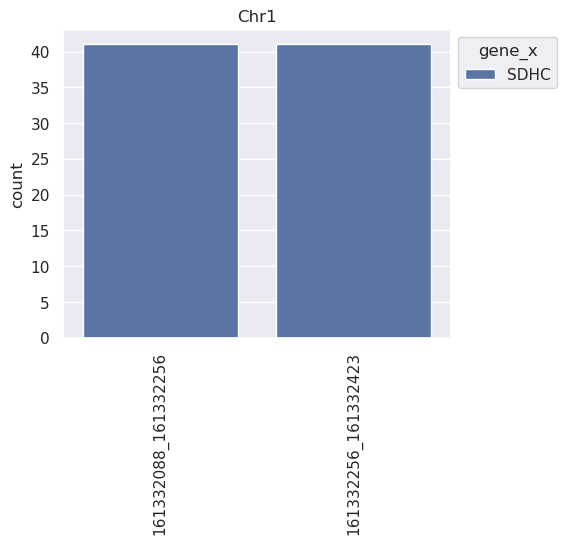

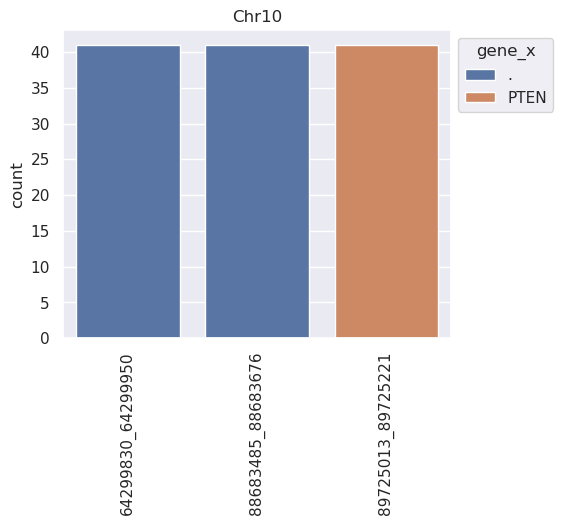

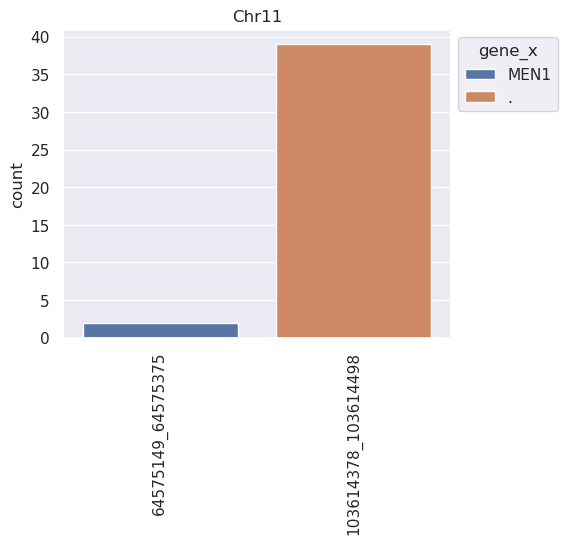

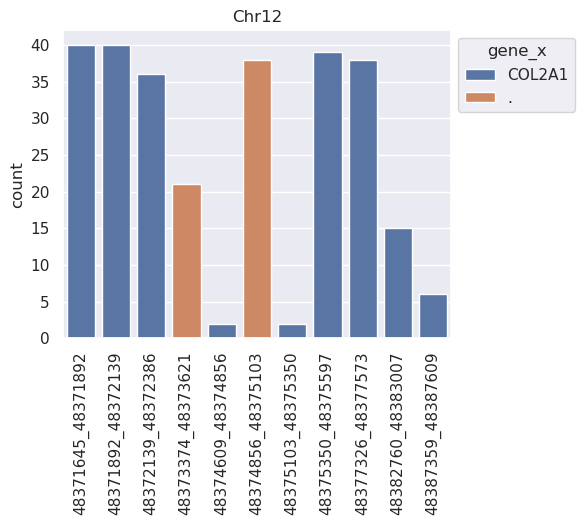

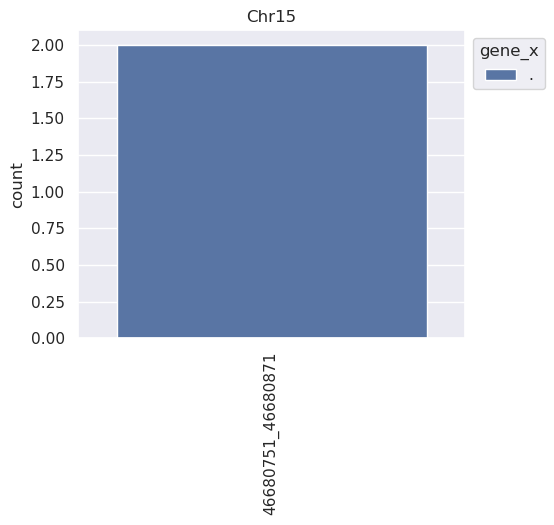

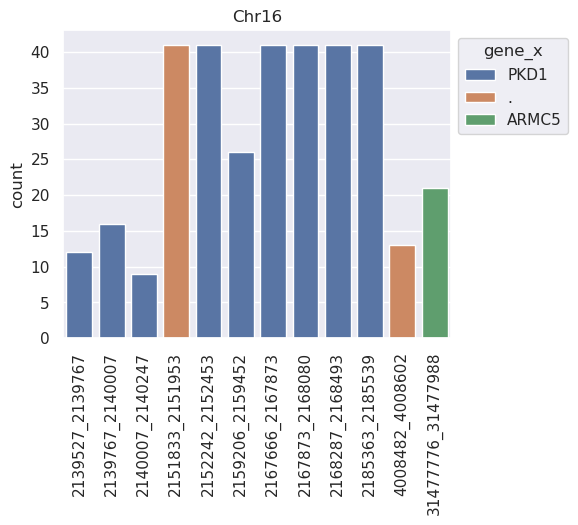

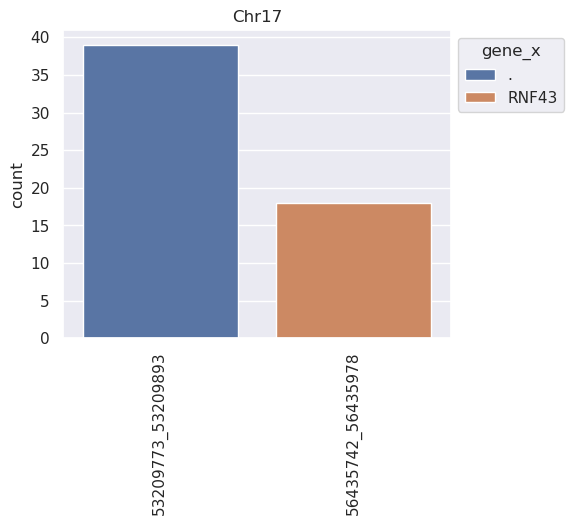

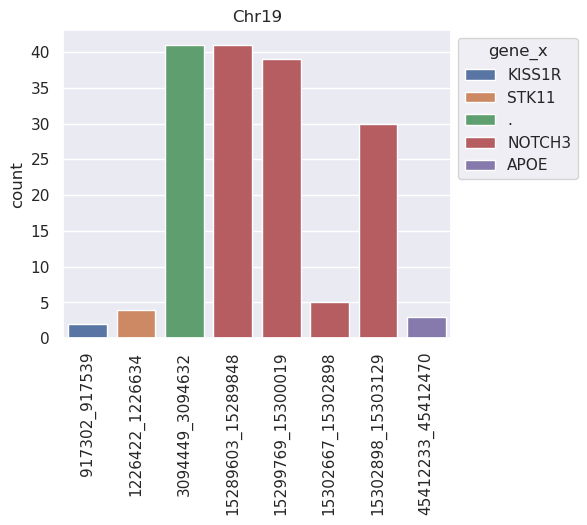

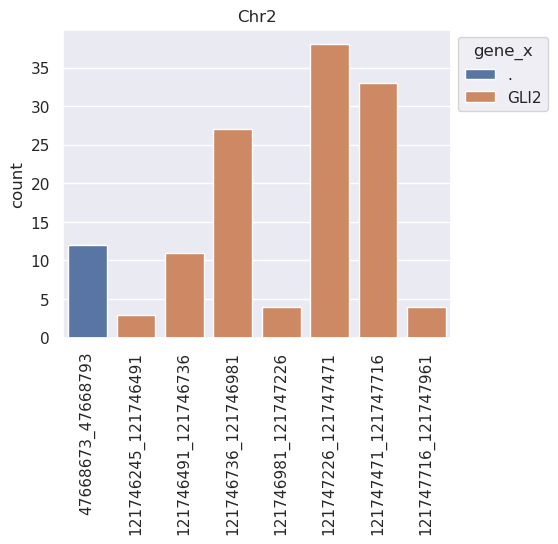

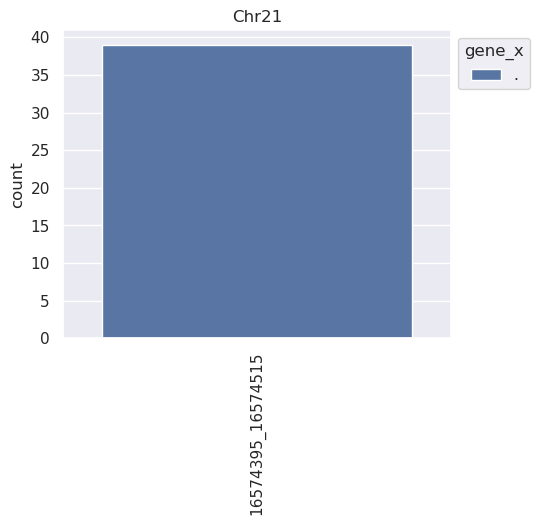

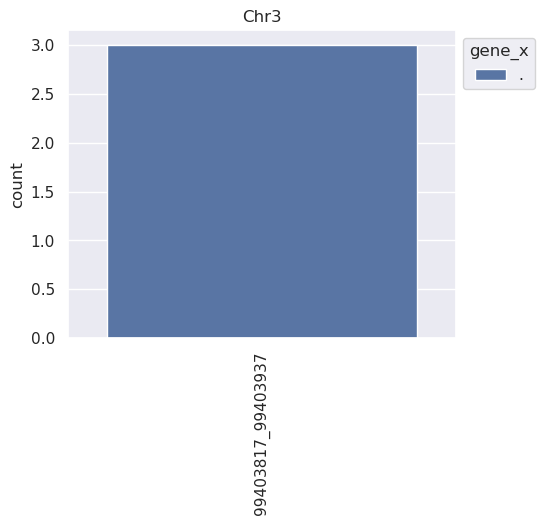

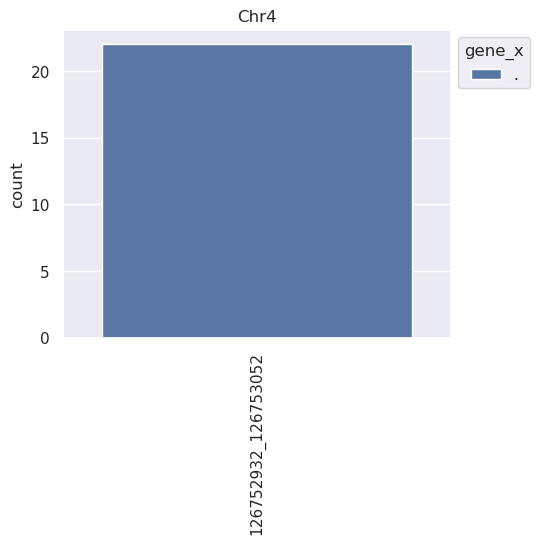

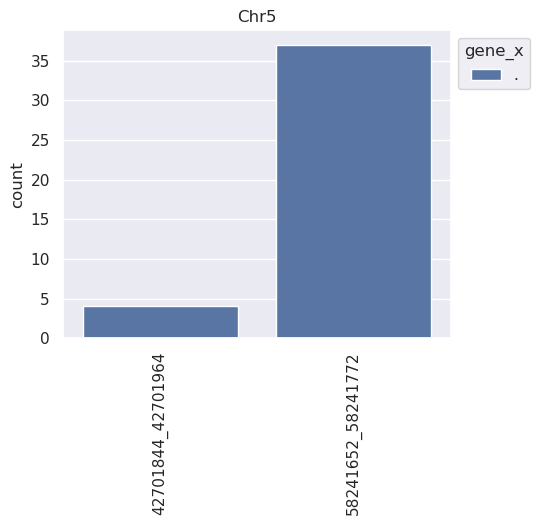

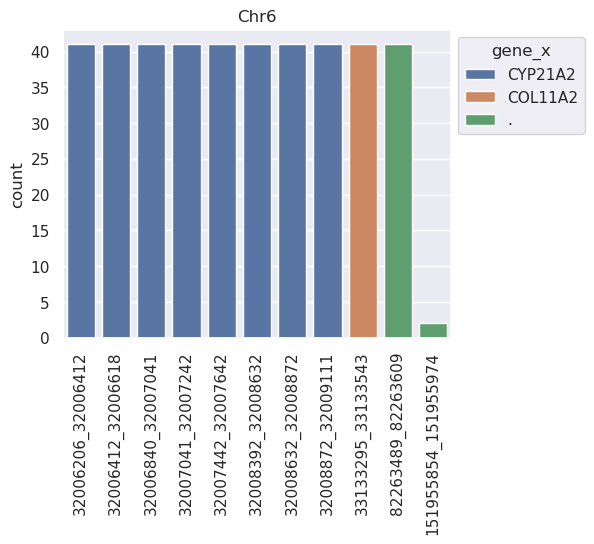

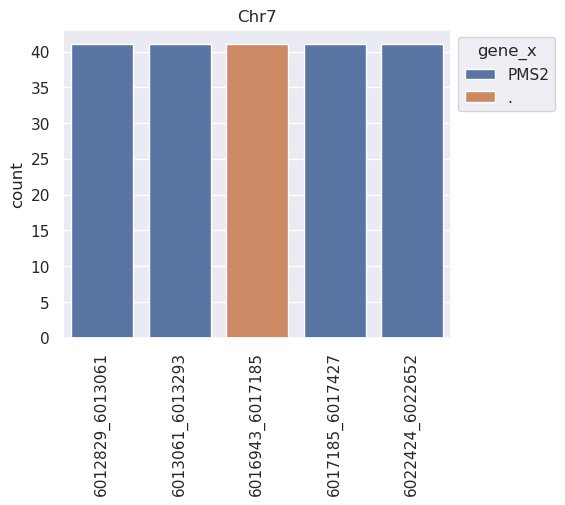

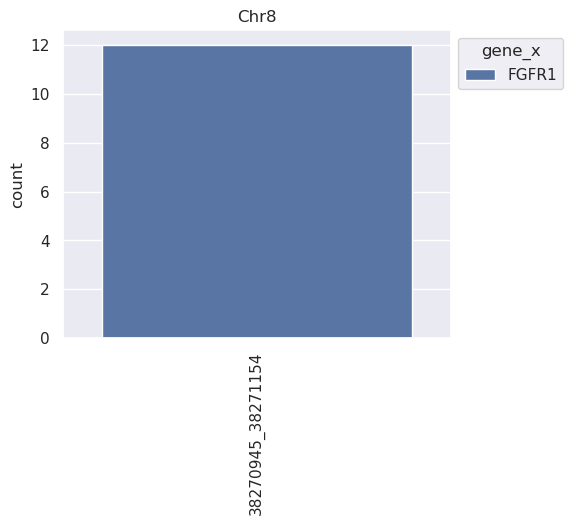

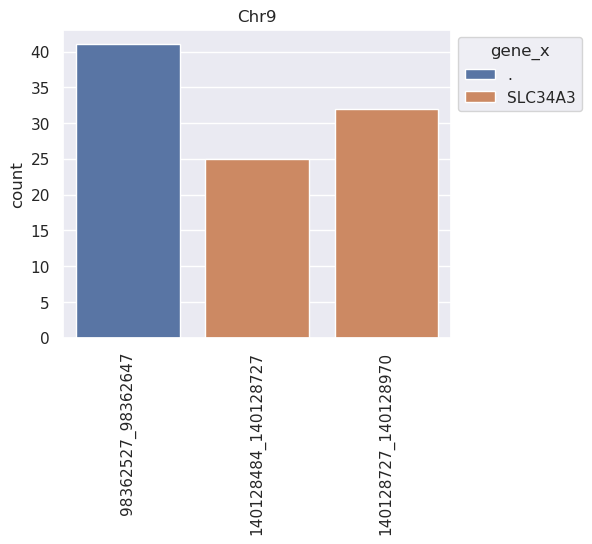

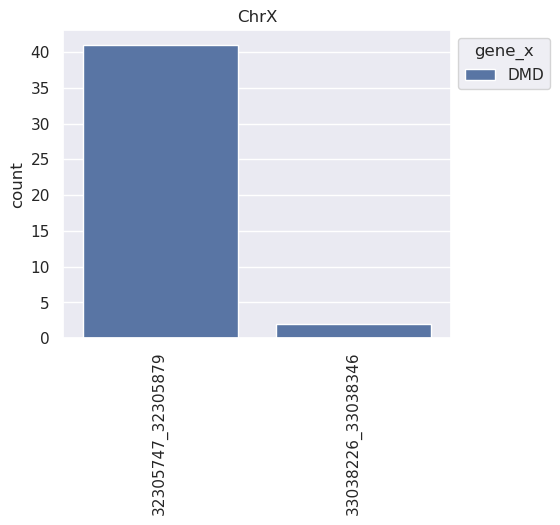

In [14]:
for c in chrom:
    temp_df = final_df[final_df['chrom']==c]
    temp_df['start'] = temp_df['start'].astype('str')
    temp_df['end'] = temp_df['end'].astype('str')
    temp_df['interval'] = temp_df['start'] + "_"+ temp_df['end']
    sns.set(rc={'figure.figsize':(5,4)})
    ax = sns.barplot(x="interval", y="count", hue="gene_x", data=temp_df, dodge=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title("Chr"+c)
    plt.xlabel("")
    plt.show()

In [15]:
final_df['count'].sum()

2097